In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
sys.path.append("..") 
import importlib
import functions.calc_dense_gas_fraction as cd
import functions.calc_unit_conversion as uc
import functions.data_class as dc

importlib.reload(cd)
importlib.reload(uc)


dpi = 400

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi
plt.style.use(['science','ieee'])
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams["text.usetex"] = False

In [11]:
# Scorpio output files.
files = ['../h5/g1040_0016.h5',  # parallel cloud
         '../h5/g1041_9015.h5']  # perpendicular cloud

# type of the simulation
file_name = ['para', 'perp']

# Line of sight for two cloud
# (z,y,x), parallel cloud -> z axis
#          perpendicular cloud -> x axis
line_of_sight = [0, 2]

# grid size of the simulation
dx = 10/480

In [42]:
# list to store the mean magnetic field and density
b_info = []
dens = []


# Read Scorpio output file.
for file, los in zip(files, line_of_sight):
    
    print(f"Reading file {file}")

    # directly read Scorpio output data.
    with h5py.File(file, 'r') as data:
        # data dimension.
        nbuf = data['nbuf'][0].astype(int)
        nx, ny, nz = data['nMesh'][:].astype(int)

        # density
        density = data['den'][nbuf:(nz + nbuf),
                                nbuf:(ny + nbuf), nbuf:(nx + nbuf)]
        # magnetic field
        bx = 0.5*(data['bxr'][nbuf:(nz + nbuf), nbuf:(ny + nbuf), nbuf:(nx + nbuf)] +
                    data['bxl'][nbuf:(nz + nbuf), nbuf:(ny + nbuf), nbuf:(nx + nbuf)])
        by = 0.5*(data['byr'][nbuf:(nz + nbuf), nbuf:(ny + nbuf), nbuf:(nx + nbuf)] +
                    data['byl'][nbuf:(nz + nbuf), nbuf:(ny + nbuf), nbuf:(nx + nbuf)])
        bz = 0.5*(data['bzr'][nbuf:(nz + nbuf), nbuf:(ny + nbuf), nbuf:(nx + nbuf)] +
                    data['bzl'][nbuf:(nz + nbuf), nbuf:(ny + nbuf), nbuf:(nx + nbuf)])
        # time
        t = data['t'][:]
    

    # calculate the density weighted magnetic field
    b_info += [cd.calc_den_weighted_mean_b(density, bx, by, bz)]
    
    # store the density field
    dens += [np.sum(density, los)*dx]

Reading file ../h5/g1040_0016.h5
Reading file ../h5/g1041_9015.h5


In [63]:
# calculate critical density
crit_dens = [cd.calc_magnetic_critial_den(uc.b_code_to_muG(b[3])) for b in b_info]

# dense gas mass
dense_mass = [np.sum(dens[i][dens[i] > crit_dens[i]])*dx**2 for i in range(2)]

# total mass
cloud_mass = [np.sum(dens[i])*dx**2 for i in range(2)]

In [75]:
# summary for calculation 
for i in range(2):
    print(f"cloud type = {file_name[i]},")
    print(f"    density weighted magnetic field = {uc.b_code_to_muG(b_info[i][3]): 50.10f} muG")
    print(f"    critical column density         = {crit_dens[i]: 50.10f} Msun.pc-2")
    print(f"    cloud mass                      = {cloud_mass[i]: 50.10f} Msun")
    print(f"    dense gas mass                  = {dense_mass[i]: 50.10f} Msun")
    print(f"    dense gass fraction             = {dense_mass[i]/cloud_mass[i]*100: 50.10f} %")
    

cloud type = para,
    density weighted magnetic field =                                      26.5716430805 muG
    critical column density         =                                     277.6036507046 Msun.pc-2
    cloud mass                      =                                   11002.1148454371 Msun
    dense gas mass                  =                                    4413.0297186780 Msun
    dense gass fraction             =                                      40.1107403501 %
cloud type = perp,
    density weighted magnetic field =                                      24.1888008147 muG
    critical column density         =                                     252.7092281037 Msun.pc-2
    cloud mass                      =                                   11002.1148454371 Msun
    dense gas mass                  =                                     950.9536251046 Msun
    dense gass fraction             =                                       8.6433711924 %


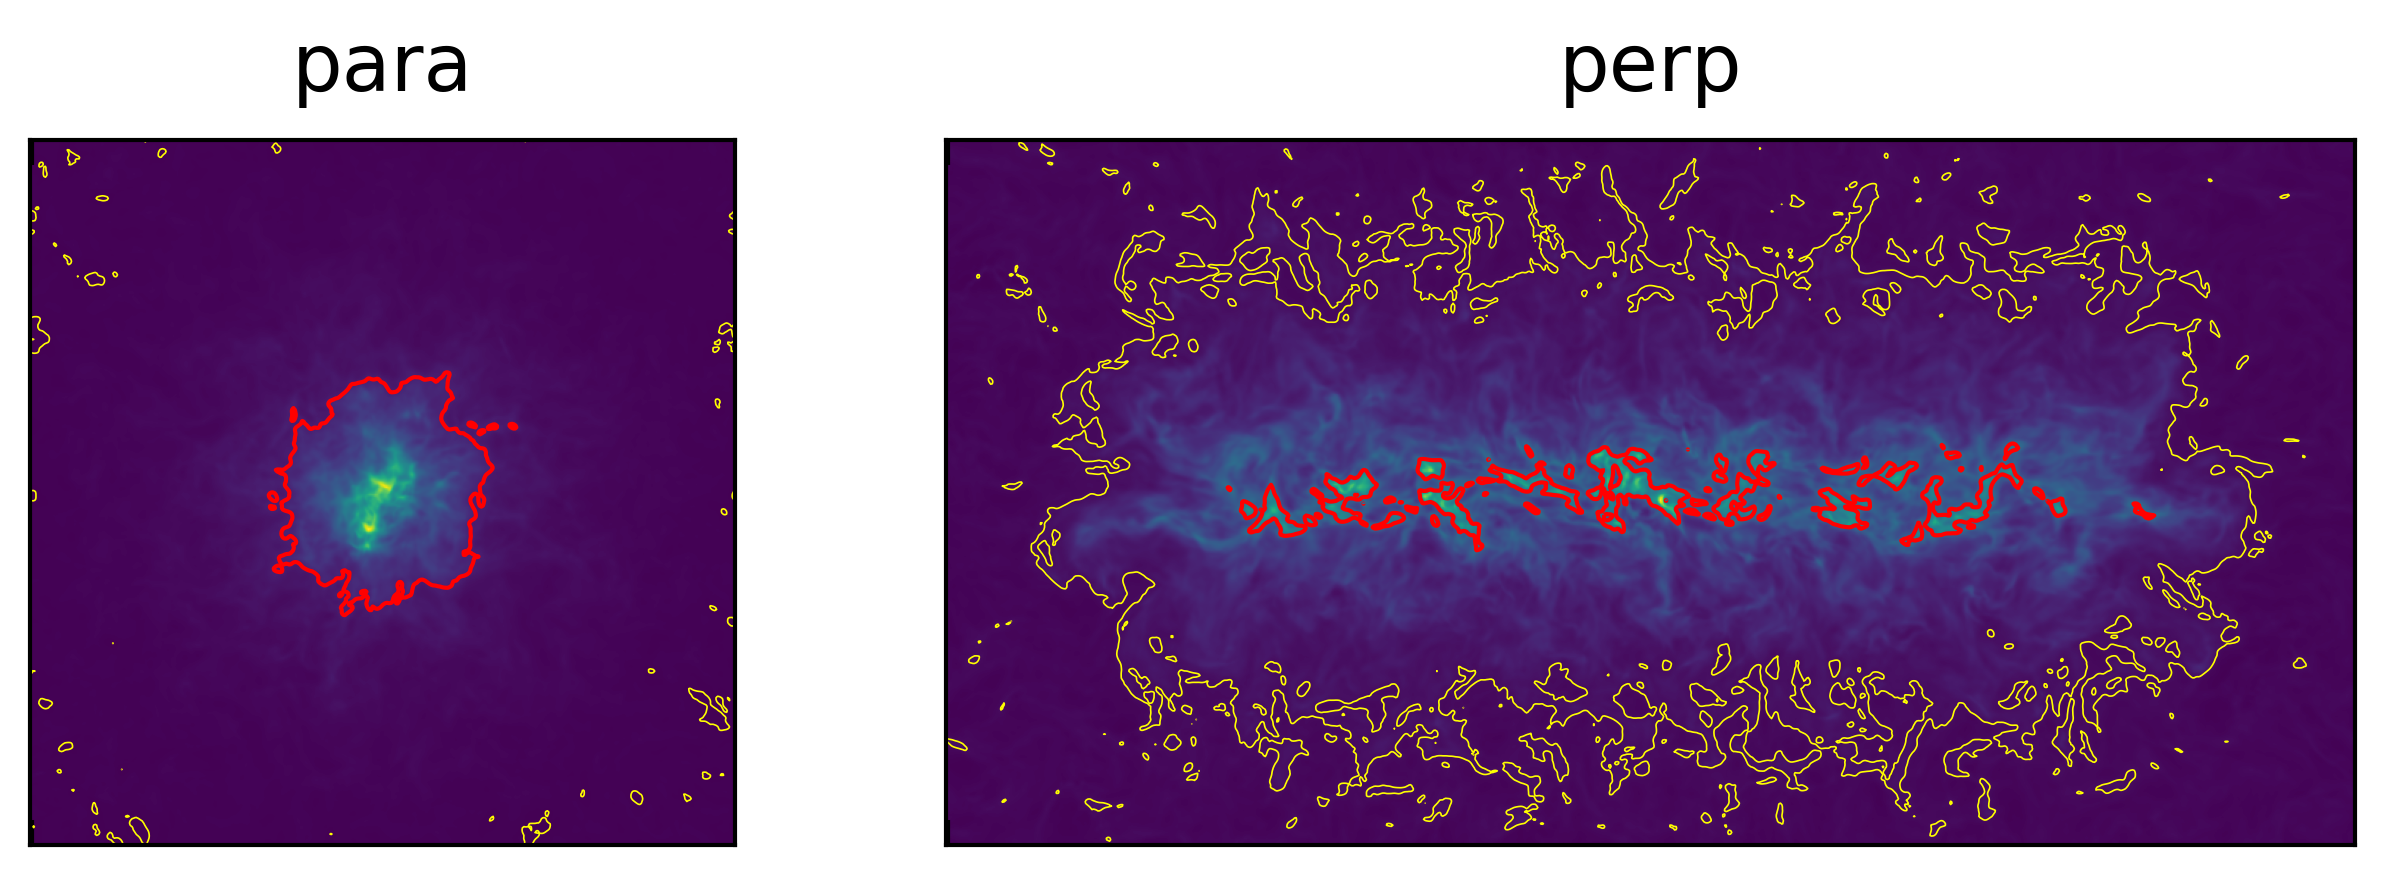

In [61]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})

for i in range(2):
    
    ax[i].imshow(dens[i].T)
    ax[i].contour(dens[i].T, levels = [30, crit_dens[i]], colors = ['yellow', 'red'],  linewidths = [0.2, 0.5])
    
    ax[i].set_xticks([1], [])
    ax[i].set_yticks([])
    ax[i].set_title(f"{file_name[i]}")

In [10]:
# data after maximum contour
files = ['../h5_max_contour/g1040_0016_binary_search.h5',
         '../h5_max_contour/g1041_9015_by_mass.h5']

# read datas.
datas = [dc.read_data(file) for file in files]

# calculate the total mass of the cloud within the contour
contour_mass = [np.sum(data['density'])*dx**3 for data in datas]

In [12]:
for i in range(2):
    print(f"{file_name[i]}, cloud mass within contour =   {contour_mass[i]:10f}")

para, cloud mass within contour =   3642.722286
perp, cloud mass within contour =   3642.722489
